In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras

tfds.disable_progress_bar()

physdev = tf.config.list_physical_devices('GPU')

if len(physdev) > 0:
    print(physdev)
    tf.config.experimental.set_memory_growth(physdev[0], True)
else:
    print('¯\_(ツ)_/¯')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
builder = tfds.builder('rock_paper_scissors')
info = builder.info

print(info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='C:\\Users\\lvenk\\tensorflow_datasets\\rock_paper_scissors\\3.0.0',
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)


# Data Discovery

In [3]:
ds = tfds.load(name='rock_paper_scissors:3.0.0')

ds_train = ds['train']
ds_test = ds['test']

print(ds_train)

<PrefetchDataset shapes: {image: (300, 300, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


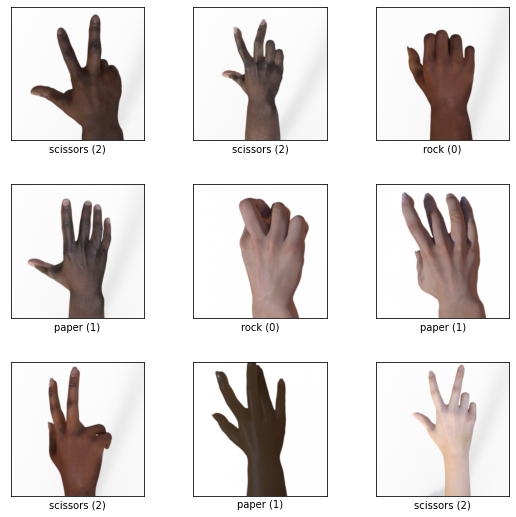

In [4]:
fig = tfds.show_examples(ds_train, info)

# Data Preparation

In [5]:
x_train_raw = np.array([example['image'].numpy() for example in ds_train])
y_train_raw = np.array([example['label'].numpy() for example in ds_train])

x_test_raw = np.array([example['image'].numpy() for example in ds_test])
y_test_raw = np.array([example['label'].numpy() for example in ds_test])

print(type(x_train_raw))
print(x_train_raw.shape)

print(type(y_train_raw))
print(y_train_raw.shape)

print(type(x_test_raw))
print(x_test_raw.shape)

print(type(y_test_raw))
print(y_test_raw.shape)

<class 'numpy.ndarray'>
(2520, 300, 300, 3)
<class 'numpy.ndarray'>
(2520,)
<class 'numpy.ndarray'>
(372, 300, 300, 3)
<class 'numpy.ndarray'>
(372,)


## Change image to grayscale

Since the objective is to detect shapes, the color doesn't interfere in their shape.

In [6]:
# Scale every value between 0 and 1
x_train = x_train_raw / 255.0
x_test = x_test_raw / 255.0

x_train = np.dot(x_train, [0.2989, 0.5870, 0.1140])
y_train = y_train_raw.copy()
# y_train = keras.utils.to_categorical(y_train_raw)

x_test = np.dot(x_test, [0.2989, 0.5870, 0.1140])
y_test = y_test_raw.copy()
# y_test = keras.utils.to_categorical(y_test_raw)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2520, 300, 300)
(2520,)
(372, 300, 300)
(372,)


2


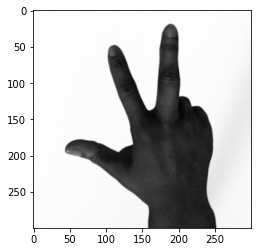

In [7]:
print(y_train[0])
plt.imshow(x_train[0], cmap='gray')

In [8]:
# Just letting the CNN in keras to know that this is a gray-scale image
x_train = x_train.reshape(2520, 300, 300, 1)
x_test = x_test.reshape(372, 300, 300, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.dtype)
print(x_test.dtype)

x_train[0].shape

float32
float32


(300, 300, 1)

# Simple Fully-Connected Model

In [9]:
model = keras.Sequential([
  keras.Input(shape=(300, 300, 1)),
  keras.layers.Flatten(), # Flatten 300x300 to 90000
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [10]:
model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
79/79 [==============================] - 3s 24ms/step - loss: 44.9520 - accuracy: 0.3846
Epoch 2/5
79/79 [==============================] - 2s 23ms/step - loss: 3.1702 - accuracy: 0.6210
Epoch 3/5
79/79 [==============================] - 2s 23ms/step - loss: 1.1074 - accuracy: 0.7588
Epoch 4/5
79/79 [==============================] - 2s 24ms/step - loss: 0.4151 - accuracy: 0.8699
Epoch 5/5
79/79 [==============================] - 2s 23ms/step - loss: 0.6918 - accuracy: 0.8279


In [11]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 0s 8ms/step - loss: 2.7528 - accuracy: 0.6774


[2.7527990341186523, 0.6774193644523621]

# Convolutional Neural Network

In [9]:
model = keras.Sequential([
    keras.Input(shape=(300, 300, 1)),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 296, 16)      4624      
_________________________________________________________________
flatten (Flatten)            (None, 1401856)           0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4205571   
Total params: 4,210,515
Trainable params: 4,210,515
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
79/79 [==============================] - 20s 167ms/step - loss: 2.9983 - accuracy: 0.6803
Epoch 2/5
79/79 [==============================] - 12s 146ms/step - loss: 0.0500 - accuracy: 0.9936
Epoch 3/5
79/79 [==============================] - 12s 146ms/step - loss: 0.0103 - accuracy: 0.9994
Epoch 4/5
79/79 [==============================] - 12s 146ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 5/5
79/79 [==============================] - 12s 146ms/step - loss: 9.6629e-04 - accuracy: 1.0000


In [11]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 1s 72ms/step - loss: 1.1251 - accuracy: 0.6478


[1.1251311302185059, 0.647849440574646]

# Improving Network to Prevent Overfitting

In [21]:
model = keras.Sequential([
    keras.Input(shape=(300, 300, 1)),
    keras.layers.AveragePooling2D(6, 3),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_3 (Average (None, 99, 99, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 97, 97, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 95, 95, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 47, 47, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 35344)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)               

In [22]:
model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
79/79 [==============================] - 2s 23ms/step - loss: 0.8236 - accuracy: 0.6074
Epoch 2/5
79/79 [==============================] - 2s 24ms/step - loss: 0.0658 - accuracy: 0.9893
Epoch 3/5
79/79 [==============================] - 2s 24ms/step - loss: 0.0134 - accuracy: 0.9983
Epoch 4/5
79/79 [==============================] - 2s 23ms/step - loss: 0.0053 - accuracy: 0.9999
Epoch 5/5
79/79 [==============================] - 2s 23ms/step - loss: 0.0024 - accuracy: 1.0000


In [23]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 0s 11ms/step - loss: 0.6675 - accuracy: 0.7527


[0.6674954891204834, 0.7526881694793701]

# Keras Tuner

In [9]:
from kerastuner import RandomSearch

In [13]:
def build_model(hp):
    model = keras.Sequential()

    model.add(keras.Input(shape=(300, 300, 1)))
    
    model.add(keras.layers.AveragePooling2D(12, 6))

    model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(32, 3, activation='relu'))

    model.add(keras.layers.MaxPool2D(2, 2))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(hp.Choice('dense1', [32, 64, 128, 256, 512]), activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

In [14]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
)

tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Trial 4 Complete [00h 00m 15s]
val_accuracy: 0.7956989407539368

Best val_accuracy So Far: 0.9112903475761414
Total elapsed time: 00h 01m 02s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


In [15]:
best_model = tuner.get_best_models()[0]
print(best_model.summary())
best_model.evaluate(x_test, y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 49, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 47, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3

[0.3626229465007782, 0.9112903475761414]

# Saving the model

In [16]:
best_model.save('./model')

# Load
# loaded_model = keras.models.load_model('./model')

INFO:tensorflow:Assets written to: ./model\assets
INFO:tensorflow:Assets written to: ./model\assets
